# FIT5202 Assignment 2A : Building Models to Predict Loan Default

## Table of Contents
*  
    * [Part 1 : Data Loading, Transformation and Exploration](#part-1)
    * [Part 2 : Feature extraction and ML training](#part-2)
    * [Part 3 : Applicant Segmentation and Knowledge sharing with K-Mean](#part-3)
    * [Part 4 : Data Ethics, Privacy, and Security](#part-4)

Please add code/markdown cells as you need.

# Part 1: Data Loading, Transformation and Exploration <a class="anchor" name="part-1"></a>
## 1.1 Data Loading
In this section, you need to load the given datasets into PySpark DataFrames and use DataFrame functions to process the data, usage of Spark SQL is discouraged. You are allowed to use third-party libraries to format the output. For plotting, different visualisation packages can be used, please ensure that you have included instructions to install the additional packages and the installation will be successful in the provided docker container(in case your marker needs to clear the notebook and rerun it).

### 1.1.1 Data Loading <a class="anchor" name="1.1"></a>
Write the code to create a SparkSession. For creating the SparkSession, you need to use a SparkConf object to configure the Spark app with a proper application name, to ensure the maximum partition size does not exceed 20MB, and to run locally with 4 CPU cores on your machine. (2%)

In [ ]:
from pyspark import SparkConf

# Set up spark to run locally with all available processors
master = "local[4]"

# Give the appropriate app name
app_name = "Assignment 2A"

# Set up configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Import SparkContext and SparkSession classes
from pyspark import SparkContext
from pyspark.sql import SparkSession

# Create a SparkSession using Melbourne time as the session timezone
spark = SparkSession.builder.config(conf=spark_conf) \
    .config("spark.sql.session.timeZone", "Australia/Melbourne") \
    .getOrCreate()

# Create a SparkContext object using SparkSession
sc = spark.sparkContext

# Set log level to ERROR
sc.setLogLevel('ERROR')

In [ ]:
## Import module

from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.types import StringType
from pyspark.sql.types import LongType
from pyspark.sql.types import DateType

from pyspark.sql.functions import col
from pyspark.sql.functions import round as round_
from pyspark.sql.functions import lit
from pyspark.sql.functions import udf
from pyspark.sql.functions import when
from pyspark.sql.functions import sum as sum_

from datetime import datetime, timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

from pyspark.ml.classification import RandomForestClassifier, GBTClassifier

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.mllib.evaluation import BinaryClassificationMetrics

from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans

1.1.2 Write code to define the schemas for previous_application and application_data, following the data types suggested in the metadata file. (3%)

In [ ]:
# Define schemas for previous_application following metadata file
columns_to_cast_previous_application = {
    "id": LongType(),
    "id_app": IntegerType(),
    "contract_type": IntegerType(),
    "hour_appr_process_start": IntegerType(),
    "channel_type": StringType(),
    "nflag_insured_on_approval": FloatType(),
    "days_decision": FloatType(),
    "days_first_drawing": FloatType(),
    "days_first_due": FloatType(),
    "days_last_due_1st_version": FloatType(),
    "days_last_due": FloatType(),
    "days_termination": FloatType(),
    "rate_down_payment": FloatType(),
    "rate_interest_primary": FloatType(),
    "rate_interest_privileged": FloatType(),
    "amt_annuity": FloatType(),
    "amt_application": FloatType(),
    "amt_credit": FloatType(),
    "amt_down_payment": FloatType(),
    "amt_goods_price": FloatType(),
    "name_cash_loan_purpose": StringType(),
    "name_contract_status": StringType(),
    "name_payment_type": StringType(),
    "code_rejection_reason": StringType(),
    "name_type_suite": StringType(),
    "name_client_type": StringType(),
    "name_goods_category": StringType(),
    "name_portfolio": StringType(),
    "name_product_type": StringType(),
    "sellerplace_area": IntegerType(),
    "name_seller_industry": StringType(),
    "cnt_payment": FloatType(),
    "name_yield_group": StringType(),
    "product_combination": StringType()
}

# Define schemas for application_data following metadata file
columns_to_cast_application = {
    "id_app": IntegerType(),
    "target": IntegerType(),
    "contract_type": IntegerType(),
    "gender": StringType(),
    "own_car": StringType(),
    "own_property": StringType(),
    "num_of_children": IntegerType(),
    "income_total": FloatType(),
    "amt_credit": FloatType(),
    "amt_annuity": FloatType(),
    "amt_goods_price": FloatType(),
    "income_type": IntegerType(),
    "education_type": IntegerType(),
    "family_status": IntegerType(),
    "housing_type": IntegerType(),
    "region_population": FloatType(),
    "days_birth": IntegerType(),
    "days_employed": IntegerType(),
    "own_car_age": FloatType(),
    "flag_mobile": IntegerType(),
    "flag_emp_phone": IntegerType(),
    "flag_work_phone": IntegerType(),
    "flag_cont_mobile": IntegerType(),
    "flag_phone": IntegerType(),
    "flag_email": IntegerType(),
    "occupation_type": IntegerType(),
    "cnt_fam_members": FloatType(),
    "weekday_app_process_start": StringType(),
    "hour_app_process_start": IntegerType(),
    "organization_type": IntegerType(),
    "credit_score_1": FloatType(),
    "credit_score_2": FloatType(),
    "credit_score_3": FloatType(),
    "days_last_phone_change": IntegerType(),
    "amt_credit_req_last_hour": FloatType(),
    "amt_credit_req_last_day": FloatType(),
    "amt_credit_req_last_week": FloatType(),
    "amt_credit_req_last_month": FloatType(),
    "amt_credit_req_last_quarter": FloatType(),
    "amt_credit_req_last_year": FloatType()
}

1.1.3 Using your schemas from step 2, write code to load all CSV files into separate data frames(note: value_dict and loan_default are simple and don’t need schemas). Print the schemas of all data frames. (2%)

In [ ]:
# Load the previous_application file into dataframe
df_previous_application = spark.read.csv("previous_application.csv",header=True)

# Cast schema datatype to the dataframe
for column, data_type in columns_to_cast_previous_application.items():
    df_previous_application = df_previous_application.withColumn(column, col(column).cast(data_type))

# Print schema
df_previous_application.printSchema()

root
 |-- id_app: integer (nullable = true)
 |-- contract_type: integer (nullable = true)
 |-- amt_annuity: float (nullable = true)
 |-- amt_application: float (nullable = true)
 |-- amt_credit: float (nullable = true)
 |-- amt_down_payment: float (nullable = true)
 |-- amt_goods_price: float (nullable = true)
 |-- hour_appr_process_start: integer (nullable = true)
 |-- rate_down_payment: float (nullable = true)
 |-- rate_interest_primary: float (nullable = true)
 |-- rate_interest_privileged: float (nullable = true)
 |-- name_cash_loan_purpose: string (nullable = true)
 |-- name_contract_status: string (nullable = true)
 |-- days_decision: float (nullable = true)
 |-- name_payment_type: string (nullable = true)
 |-- code_rejection_reason: string (nullable = true)
 |-- name_type_suite: string (nullable = true)
 |-- name_client_type: string (nullable = true)
 |-- name_goods_category: string (nullable = true)
 |-- name_portfolio: string (nullable = true)
 |-- name_product_type: string (n

In [ ]:
# Load the application_data file into dataframe
df_application = spark.read.csv("application_data.csv",header=True)

# Cast schema datatype to the dataframe
for column, data_type in columns_to_cast_application.items():
    df_application = df_application.withColumn(column, col(column).cast(data_type))

# Print schema
df_application.printSchema()

root
 |-- id_app: integer (nullable = true)
 |-- target: integer (nullable = true)
 |-- contract_type: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- own_car: string (nullable = true)
 |-- own_property: string (nullable = true)
 |-- num_of_children: integer (nullable = true)
 |-- income_total: float (nullable = true)
 |-- amt_credit: float (nullable = true)
 |-- amt_annuity: float (nullable = true)
 |-- amt_goods_price: float (nullable = true)
 |-- income_type: integer (nullable = true)
 |-- education_type: integer (nullable = true)
 |-- family_status: integer (nullable = true)
 |-- housing_type: integer (nullable = true)
 |-- region_population: float (nullable = true)
 |-- days_birth: integer (nullable = true)
 |-- days_employed: integer (nullable = true)
 |-- own_car_age: float (nullable = true)
 |-- flag_mobile: integer (nullable = true)
 |-- flag_emp_phone: integer (nullable = true)
 |-- flag_work_phone: integer (nullable = true)
 |-- flag_cont_mobile: integer

In [ ]:
# Load value_dict into data frame
df_value_dict = spark.read.csv("value_dict.csv",header=True)

# Print schema
df_value_dict.printSchema()

root
 |-- id: string (nullable = true)
 |-- category: string (nullable = true)
 |-- key: string (nullable = true)
 |-- value: string (nullable = true)



In [ ]:
# Load loan_default into data frame
df_loan_default = spark.read.csv("loan_default.csv",header=True)

# Print schema
df_loan_default.printSchema()

root
 |-- id_app: string (nullable = true)
 |-- is_default: string (nullable = true)



### 1.2 Data Transformation and Create Features <a class="anchor" name="1.2"></a>
In this step, we’re going to perform data transformation and create some new features using existing information. (note: you are allowed to use your own code from assignment 1 for some transformation.)  
Perform the following tasks on the application_data data frame:

1.2.1 Create a new column called loan_to_income_ratio(loan to income ratio) defined as amt_credit/income_total.

In [ ]:
# Create loan_to_income_ratio as amt_credit/income_total
df_application = df_application.withColumn("loan_to_income_ratio", round_(col("amt_credit")/col("income_total"), 4))

# Display the result
df_application.select("id_app", "amt_credit", "income_total", "loan_to_income_ratio").show()

+------+----------+------------+--------------------+
|id_app|amt_credit|income_total|loan_to_income_ratio|
+------+----------+------------+--------------------+
|118100|  667237.5|    247500.0|              2.6959|
|110133| 1374480.0|    112500.0|             12.2176|
|110215|  545040.0|    166500.0|              3.2735|
|194051|  900000.0|    112500.0|                 8.0|
|110368| 1237684.5|    261000.0|              4.7421|
|110498|  179865.0|    157500.0|               1.142|
|110561| 1256400.0|    157500.0|              7.9771|
|110836|  454500.0|    126000.0|              3.6071|
|110985|  454500.0|     76500.0|              5.9412|
|109621|  513531.0|     67500.0|              7.6079|
|111097|  343800.0|    180000.0|                1.91|
|111245|  612612.0|    157500.0|              3.8896|
|111288| 1125000.0|    202500.0|              5.5556|
|165103|  675000.0|    135000.0|                 5.0|
|111444|  308133.0|     94500.0|              3.2607|
|111509|  808650.0|     9000

1.2.2. Perform age bucketing and create a new string column called age_bucket and set the value below:  
age < 25: Y  
25 <= age <35: E  
35 <= age <45: M  
45 <= age < 55: L  
55 <= age < 65: N  
Age >= 65: R

In [ ]:
## Reuse date_calculator and age_calculator function from assignment 1

# This function takes a base date and a relative number to calculate the target date
def date_calculator(base_date, relative_number):
    base_date = str(base_date)

    if relative_number is None:
        return base_date
    else:
        relative_number = int(relative_number)
        base_date_datetime = datetime.strptime(base_date, "%d/%m/%Y")
        result_date = base_date_datetime + timedelta(days = relative_number)
        return result_date.date()

# This function takes birthdate and current_date to generate age
def age_calculator(birthdate, current_date):
        if birthdate is not None:
            current_date = datetime.strptime(current_date, "%d/%m/%Y")
            age = current_date.year - birthdate.year - ((current_date.month, current_date.day) < (birthdate.month, birthdate.day))
            return age
        else:
            return None

# This function takes age and produce age bucket value
def age_bucket(age):
    age = int(age)
    if age < 25:
        age_bucket = "Y"
    elif age < 35:
        age_bucket = "E"
    elif age < 45:
        age_bucket = "M"
    elif age < 55:
        age_bucket = "L"
    elif age < 65:
        age_bucket = "N"
    else:
        age_bucket = "R"
    return age_bucket

In [ ]:
## Calculate birthday
current_date = datetime.today().strftime("%d/%m/%Y")

# Register date_calculator as udf
date_calculator_udf = udf(date_calculator, DateType())

# Generate birthdate
df_application = df_application.withColumn("birthday", date_calculator_udf(lit(current_date), col("days_birth")))

## Calculate age

# Register age_calculator as udf
age_calculator_udf = udf(age_calculator, IntegerType())

# Generate age
df_application = df_application.withColumn("age", age_calculator_udf(col("birthday"), lit(current_date)))

## Calculate age_bucket

# Register age_bucket as udf
age_bucket_udf = udf(age_bucket, StringType())

# Generate age bucket
df_application = df_application.withColumn("age_bucket", age_bucket_udf(col("age")))

df_application.select("id_app", "days_birth", "birthday", "age", "age_bucket").show()

+------+----------+----------+---+----------+
|id_app|days_birth|  birthday|age|age_bucket|
+------+----------+----------+---+----------+
|118100|    -11258|1993-04-08| 30|         E|
|110133|    -11044|1993-11-08| 30|         E|
|110215|    -17115|1977-03-26| 46|         L|
|194051|    -17855|1975-03-17| 48|         L|
|110368|    -22818|1961-08-14| 62|         N|
|110498|    -21183|1966-02-04| 57|         N|
|110561|     -9537|1997-12-24| 26|         E|
|110836|    -13351|1987-07-16| 36|         M|
|110985|    -16847|1977-12-19| 46|         L|
|109621|    -10828|1994-06-12| 29|         E|
|111097|    -18279|1974-01-17| 50|         L|
|111245|    -19710|1970-02-16| 53|         L|
|111288|    -11636|1992-03-26| 31|         E|
|165103|    -12011|1991-03-17| 32|         E|
|111444|    -13402|1987-05-26| 36|         M|
|111509|    -19869|1969-09-10| 54|         L|
|111556|    -17096|1977-04-14| 46|         L|
|111642|    -17354|1976-07-30| 47|         L|
|111869|    -21198|1966-01-20| 58|

1.2.3 Create a new string column named credit_worthiness. It takes the average value of credit_score_1,2,3 (note: replace null value with 0.5, not 0). If the average >= 0.7, set credit_worthiness to “high”; 0.4 <= average <= 0.7 set to “medium”, < 0.4 set to “low”.

In [ ]:
# This function assigns credit worthiness bucket to avarage credit score
def credit_bucket(credit_average):
    credit_average = float(credit_average)
    if credit_average < 0.4:
        credit_bucket = "low"
    elif credit_average < 0.7:
        credit_bucket = "medium"
    else:
        credit_bucket = "high"

    return credit_bucket

In [ ]:
## Reuse code from assignment 1
# Replace null value in credit score columns
df_application = df_application.withColumn("credit_score_1", when(col("credit_score_1").isNull(), 0.5).otherwise(col("credit_score_1")))
df_application = df_application.withColumn("credit_score_2", when(col("credit_score_2").isNull(), 0.5).otherwise(col("credit_score_2")))
df_application = df_application.withColumn("credit_score_3", when(col("credit_score_3").isNull(), 0.5).otherwise(col("credit_score_3")))

# Calculate average credit score
df_application = (df_application
                  .withColumn("average_credit_score", (col("credit_score_1") + col("credit_score_2") + col("credit_score_3"))/3)
                  .withColumn("average_credit_score", round_(col("average_credit_score"), 4))
                 )



## Calculate credit_bucket

# Register credit_bucket as udf
credit_bucket_udf = udf(credit_bucket, StringType())

# Generate age bucket
df_application = df_application.withColumn("credit_bucket", credit_bucket_udf(col("average_credit_score")))


# Display the result
df_application.select("id_app", "average_credit_score", "credit_bucket").show()

+------+--------------------+-------------+
|id_app|average_credit_score|credit_bucket|
+------+--------------------+-------------+
|118100|              0.5661|       medium|
|110133|              0.6316|       medium|
|110215|              0.5173|       medium|
|194051|              0.5719|       medium|
|110368|              0.5137|       medium|
|110498|              0.3842|          low|
|110561|              0.3959|          low|
|110836|              0.6202|       medium|
|110985|               0.398|          low|
|109621|              0.4005|       medium|
|111097|              0.4679|       medium|
|111245|              0.5546|       medium|
|111288|              0.5762|       medium|
|165103|              0.4997|       medium|
|111444|              0.4232|       medium|
|111509|              0.7193|         high|
|111556|              0.4272|       medium|
|111642|              0.6035|       medium|
|111869|              0.4785|       medium|
|158585|              0.4458|   

1.2.4 Create 4 columns: num_of_prev_app(number of previous applications), num_of_approved_app (number of approved applications), total_credit (sum of credit of all approved previous applications), total_credit_to_income_ratio (total credit/income).  (note: you need to join previous applications to fill in the values.)

In [ ]:
## num_of_prev_app(number of previous applications)

# Get the number of previous applications
df_num_of_prev_app = (df_previous_application
                      .groupBy("id_app")
                      .count()
                     )

# Join the number of previous applications with application
# For those without previous application, set the count to 0
df_application = (df_application
                  .join(df_num_of_prev_app, df_application.id_app == df_num_of_prev_app.id_app, "left_outer")
                  .drop(df_num_of_prev_app["id_app"])
                  .withColumnRenamed("count", "num_of_prev_app")
                  .withColumn("num_of_prev_app", when(col("num_of_prev_app").isNull(), 0).otherwise(col("num_of_prev_app")))
                 )

# Display the result
df_application.select("id_app", "num_of_prev_app").show()

+------+---------------+
|id_app|num_of_prev_app|
+------+---------------+
|118100|              7|
|110133|              3|
|110215|              8|
|194051|              5|
|110368|              2|
|110498|              8|
|110561|              3|
|110836|              2|
|110985|              9|
|109621|              2|
|111097|              1|
|111245|              0|
|111288|              7|
|165103|              3|
|111444|              2|
|111509|              3|
|111556|              3|
|111642|              7|
|111869|              4|
|158585|              2|
+------+---------------+
only showing top 20 rows



In [ ]:
## num_of_approved_app (number of approved applications)

# Get the number of approved applications
df_num_of_approved_app = (df_previous_application
                          .filter(col("name_contract_status") == "Approved")
                          .groupBy("id_app")
                          .count()
                         )

# Join the number of approved applications with application
# For those without approved applications, set the count to 0
df_application = (df_application
                  .join(df_num_of_approved_app, df_application.id_app == df_num_of_approved_app.id_app, "left_outer")
                  .drop(df_num_of_approved_app["id_app"])
                  .withColumnRenamed("count", "num_of_approved_app")
                  .withColumn("num_of_approved_app", when(col("num_of_approved_app").isNull(), 0).otherwise(col("num_of_approved_app")))
                 )

# Display the result
df_application.select("id_app", "num_of_approved_app").show()

+------+-------------------+
|id_app|num_of_approved_app|
+------+-------------------+
|118100|                  2|
|110133|                  3|
|110215|                  2|
|194051|                  3|
|110368|                  2|
|110498|                  5|
|110561|                  2|
|110836|                  2|
|110985|                  3|
|109621|                  2|
|111097|                  1|
|111245|                  0|
|111288|                  7|
|165103|                  2|
|111444|                  2|
|111509|                  1|
|111556|                  3|
|111642|                  7|
|111869|                  1|
|158585|                  1|
+------+-------------------+
only showing top 20 rows



In [ ]:
## total_credit (sum of credit of all approved previous applications)

# Get the sum of credit of all approved previous applications
df_total_credit = (df_previous_application
                   .filter(col("name_contract_status") == "Approved")
                   .groupBy("id_app")
                   .agg(sum_("amt_credit").alias("total_credit"))
                   .withColumn("total_credit", round_(col("total_credit"), 1))
                  )

# Join the sum of credit of all approved previous applications with application
# For those without approved previous applications, set the amount to 0
df_application = (df_application
                  .join(df_total_credit, df_application.id_app == df_total_credit.id_app, "left_outer")
                  .drop(df_total_credit["id_app"])
                  .withColumn("total_credit", when(col("total_credit").isNull(), 0).otherwise(col("total_credit")))
                 )

# Display the result
df_application.select("id_app", "total_credit").show()

+------+------------+
|id_app|total_credit|
+------+------------+
|118100|    381577.5|
|110133|    238765.5|
|110215|    248575.5|
|194051|    300118.5|
|110368|   1428313.5|
|110498|   2067736.5|
|110561|    159034.5|
|110836|     55183.5|
|110985|    220329.0|
|109621|    219226.5|
|111097|    225000.0|
|111245|         0.0|
|111288|    402039.0|
|165103|    579438.0|
|111444|     98595.0|
|111509|     90000.0|
|111556|    150376.5|
|111642|   1900228.5|
|111869|    254700.0|
|158585|     35208.0|
+------+------------+
only showing top 20 rows



In [ ]:
## total_credit_to_income_ratio (total credit/income)

# Calculate total_credit_to_income_ratio
df_application = (df_application
                  .withColumn("total_credit_to_income_ratio", col("total_credit")/col("income_total"))
                  .withColumn("total_credit_to_income_ratio", round_(col("total_credit_to_income_ratio"), 2))
                 )

# Display the result
df_application.select("id_app", "total_credit_to_income_ratio").show()

+------+----------------------------+
|id_app|total_credit_to_income_ratio|
+------+----------------------------+
|118100|                        1.54|
|110133|                        2.12|
|110215|                        1.49|
|194051|                        2.67|
|110368|                        5.47|
|110498|                       13.13|
|110561|                        1.01|
|110836|                        0.44|
|110985|                        2.88|
|109621|                        3.25|
|111097|                        1.25|
|111245|                         0.0|
|111288|                        1.99|
|165103|                        4.29|
|111444|                        1.04|
|111509|                         1.0|
|111556|                        0.48|
|111642|                        7.04|
|111869|                        1.89|
|158585|                        0.39|
+------+----------------------------+
only showing top 20 rows



1.2.5 Replace education_type, occupation_type, income_type and family_status with matching strings from value_dict (hint: consider reusing code from your A1).

In [ ]:
## education_type

# Separate education_type key value pair from value dictionary
df_education_type = (df_value_dict
                     .filter(col("category") == "education_type")
                     .drop(col("id"), col("category"))
                    )
# Convert education_type dataframe to dictionary
education_type_dict = {x[1]: x[0] for x in df_education_type.collect()}

# Adjust education_type datatype, apply replace function based on dictionary
df_application = (df_application
                  .withColumn("education_type", col("education_type").cast(StringType()))
                  .replace(education_type_dict, subset = ["education_type"])
                 )

# Display the result
df_application.select("id_app", "education_type").show()

+------+--------------------+
|id_app|      education_type|
+------+--------------------+
|118100|    Higher education|
|110133|Secondary / secon...|
|110215|Secondary / secon...|
|194051|Secondary / secon...|
|110368|    Higher education|
|110498|Secondary / secon...|
|110561|    Higher education|
|110836|Secondary / secon...|
|110985|    Higher education|
|109621|Secondary / secon...|
|111097|Secondary / secon...|
|111245|Secondary / secon...|
|111288|Secondary / secon...|
|165103|Secondary / secon...|
|111444|     Lower secondary|
|111509|Secondary / secon...|
|111556|Secondary / secon...|
|111642|Secondary / secon...|
|111869|Secondary / secon...|
|158585|Secondary / secon...|
+------+--------------------+
only showing top 20 rows



In [ ]:
## occupation_type

# Separate occupation_type key value pair from value dictionary
df_occupation_type = (df_value_dict
                     .filter(col("category") == "occupation_type")
                     .drop(col("id"), col("category"))
                    )
# Convert occupation_type dataframe to dictionary
occupation_type_dict = {x[1]: x[0] for x in df_occupation_type.collect()}

# Adjust occupation_type datatype, apply replace function based on dictionary
df_application = (df_application
                  .withColumn("occupation_type", col("occupation_type").cast(StringType()))
                  .replace(occupation_type_dict, subset = ["occupation_type"])
                 )

# Display the result
df_application.select("id_app", "occupation_type").show()

+------+--------------------+
|id_app|     occupation_type|
+------+--------------------+
|118100|            Laborers|
|110133|         Sales staff|
|110215|          Core staff|
|194051|      Security staff|
|110368|             (Empty)|
|110498|             (Empty)|
|110561|         Accountants|
|110836|             (Empty)|
|110985|          Core staff|
|109621|         Accountants|
|111097|  Low-skill Laborers|
|111245|            Laborers|
|111288|             Drivers|
|165103|             Drivers|
|111444|            Laborers|
|111509|            Laborers|
|111556|            Laborers|
|111642|            Laborers|
|111869|             (Empty)|
|158585|High skill tech s...|
+------+--------------------+
only showing top 20 rows



In [ ]:
## income_type

# Separate income_type key value pair from value dictionary
df_income_type = (df_value_dict
                     .filter(col("category") == "income_type")
                     .drop(col("id"), col("category"))
                    )
# Convert income_type dataframe to dictionary
income_type_dict = {x[1]: x[0] for x in df_income_type.collect()}

# Adjust income_type datatype, apply replace function based on dictionary
df_application = (df_application
                  .withColumn("income_type", col("income_type").cast(StringType()))
                  .replace(income_type_dict, subset = ["income_type"])
                 )

# Display the result
df_application.select("id_app", "income_type").show()

+------+--------------------+
|id_app|         income_type|
+------+--------------------+
|118100|             Working|
|110133|Commercial associate|
|110215|             Working|
|194051|             Working|
|110368|           Pensioner|
|110498|           Pensioner|
|110561|Commercial associate|
|110836|Commercial associate|
|110985|Commercial associate|
|109621|             Working|
|111097|             Working|
|111245|             Working|
|111288|             Working|
|165103|             Working|
|111444|             Working|
|111509|             Working|
|111556|             Working|
|111642|Commercial associate|
|111869|           Pensioner|
|158585|             Working|
+------+--------------------+
only showing top 20 rows



In [ ]:
## family_status

# Separate family_status key value pair from value dictionary
df_family_status = (df_value_dict
                     .filter(col("category") == "family_status")
                     .drop(col("id"), col("category"))
                    )
# Convert family_status dataframe to dictionary
family_status_dict = {x[1]: x[0] for x in df_family_status.collect()}

# Adjust family_status datatype, apply replace function based on dictionary
df_application = (df_application
                  .withColumn("family_status", col("family_status").cast(StringType()))
                  .replace(family_status_dict, subset = ["family_status"])
                 )

# Display the result
df_application.select("id_app", "family_status").show()

+------+--------------------+
|id_app|       family_status|
+------+--------------------+
|118100|             Married|
|110133|             Married|
|110215|Single / not married|
|194051|      Civil marriage|
|110368|             Married|
|110498|             Married|
|110561|Single / not married|
|110836|             Married|
|110985|      Civil marriage|
|109621|             Married|
|111097|             Married|
|111245|      Civil marriage|
|111288|             Married|
|165103|           Separated|
|111444|Single / not married|
|111509|             Married|
|111556|           Separated|
|111642|             Married|
|111869|Single / not married|
|158585|      Civil marriage|
+------+--------------------+
only showing top 20 rows



1.2.6 Join the loan_default data frame and add is_default to application data. We’ll use this column as the label.

In [ ]:
df_application = (df_application
                  .join(df_loan_default, df_application.id_app == df_loan_default.id_app)
                  .drop(df_loan_default["id_app"])
                 )

df_application.select("id_app", "is_default").show()

+------+----------+
|id_app|is_default|
+------+----------+
|136948|      true|
|185200|     false|
|138411|      true|
|289291|      true|
|289534|      true|
|289538|      true|
|120608|      true|
|120823|      true|
|120841|      true|
|289899|      true|
|146914|      true|
|121068|      true|
|250505|      true|
|142122|      true|
|154029|      true|
|230145|      true|
|121739|      true|
|122031|      true|
|295779|      true|
|190812|      true|
+------+----------+
only showing top 20 rows



Print 10 records from the application_data data frame.

In [ ]:
df_application.show(10)

+------+------+-------------+------+-------+------------+---------------+------------+----------+-----------+---------------+--------------------+--------------------+--------------------+------------+-----------------+----------+-------------+-----------+-----------+--------------+---------------+----------------+----------+----------+---------------+---------------+-------------------------+----------------------+-----------------+-------------------+-------------------+-------------------+----------------------+------------------------+-----------------------+------------------------+-------------------------+---------------------------+------------------------+--------------------+----------+---+----------+--------------------+-------------+---------------+-------------------+------------+----------------------------+----------+
|id_app|target|contract_type|gender|own_car|own_property|num_of_children|income_total|amt_credit|amt_annuity|amt_goods_price|         income_type|      edu

### 1.3 Exploring the Data <a class="anchor" name="1.3"></a>
1.3.1 With the transformed data frame from 1.2, write code to show the basic statistics (3%) (pandas is allowed for this task):  
a) For each numeric column, show count, mean, stddev, min, max, 25 percentile, 50 percentile, and 75 percentile;  
b) For each non-numeric column, display the top 5 based on counts in descending order;  
c) For each boolean column, display the value and count(i.e., two rows in total).

In [ ]:
# Convert pyspark dataframe to pandas dataframe
df_application_pd = df_application.toPandas()

# Display the result
display(df_application_pd)

,id_app,target,contract_type,gender,own_car,own_property,num_of_children,income_total,amt_credit,amt_annuity,...,birthday,age,age_bucket,average_credit_score,credit_bucket,num_of_prev_app,num_of_approved_app,total_credit,total_credit_to_income_ratio,is_default
0,118100,0,2,F,Y,Y,1,247500.0,667237.5,52848.0,...,1993-04-08,30,E,0.5661,medium,7,2,381577.5,1.54,false
1,110133,0,2,F,N,Y,2,112500.0,1374480.0,49500.0,...,1993-11-08,30,E,0.6316,medium,3,3,238765.5,2.12,false
2,110215,0,2,F,N,Y,0,166500.0,545040.0,26640.0,...,1977-03-26,46,L,0.5173,medium,8,2,248575.5,1.49,false
3,194051,0,2,F,N,N,0,112500.0,900000.0,24750.0,...,1975-03-17,48,L,0.5719,medium,5,3,300118.5,2.67,false
4,110368,0,2,F,N,Y,0,261000.0,1237684.5,47272.5,...,1961-08-14,62,N,0.5137,medium,2,2,1428313.5,5.47,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172586,291519,0,2,F,N,Y,1,135000.0,252000.0,18468.0,...,1968-12-28,55,N,0.4866,medium,10,6,632164.5,4.68,false
172587,297727,0,2,F,N,Y,0,117000.0,517788.0,16668.0,...,1966-12-26,57,N,0.5752,medium,6,3,625725.0,5.35,false
172588,298681,1,2,M,N,N,0,247500.0,942300.0,34749.0,...,1999-10-16,24,Y,0.3566,low,4,3,356611.5,1.44,false
172589,298750,0,2,F,N,Y,0,198000.0,694773.0,33552.0,...,1984-03-04,39,M,0.5863,medium,17,7,2297043.0,11.60,false


In [ ]:
# Manually separate numerical columns, non-numerical columns and boolean columns
num_cols = ['total_credit', 'own_car_age', 'days_birth', 'credit_score_2', 'num_of_prev_app', 'num_of_children', 'amt_credit_req_last_month', 'credit_score_1', 'days_last_phone_change', 'age', 'amt_credit_req_last_day', 'amt_annuity', 'region_population', 'amt_credit', 'amt_goods_price', 'total_credit_to_income_ratio', 'amt_credit_req_last_hour', 'num_of_approved_app', 'days_employed', 'income_total', 'amt_credit_req_last_week', 'cnt_fam_members', 'loan_to_income_ratio', 'average_credit_score', 'amt_credit_req_last_year', 'amt_credit_req_last_quarter', 'credit_score_3']
non_num_cols = ['id_app', 'contract_type', 'housing_type', 'hour_app_process_start', 'organization_type', 'gender', 'income_type', 'education_type', 'family_status', 'occupation_type', 'weekday_app_process_start', 'birthday', 'age_bucket', 'credit_bucket']
boolean_cols = ['target', 'flag_mobile', 'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email', 'own_car', 'own_property', 'is_default']

In [ ]:
# Produce count, mean, stddev, min, max, 25 percentile, 50 percentile, and 75 percentile for numerical columns
summary_num_cols = df_application_pd[num_cols].describe()
print(summary_num_cols)

       total_credit   own_car_age     days_birth  credit_score_2  \
count  1.725910e+05  58703.000000  172591.000000    1.725910e+05   
mean   5.796704e+05     12.039402  -16026.153084    5.139773e-01   
std    7.572869e+05     11.937061    4367.826105    1.913041e-01   
min    0.000000e+00      0.000000  -25201.000000    8.000000e-08   
25%    1.077165e+05      5.000000  -19672.000000    3.915323e-01   
50%    2.841075e+05      9.000000  -15728.000000    5.654296e-01   
75%    7.539930e+05     15.000000  -12395.500000    6.637537e-01   
max    1.037038e+07     69.000000   -7673.000000    8.549997e-01   

       num_of_prev_app  num_of_children  amt_credit_req_last_month  \
count    172591.000000    172591.000000              149402.000000   
mean          4.579659         0.419228                   0.266255   
std           4.163129         0.724401                   0.914857   
min           0.000000         0.000000                   0.000000   
25%           2.000000         0.0000

In [ ]:
# Display the top 5 based on counts in descending order
for index, column in enumerate(non_num_cols):
    top_5 = "top_5_" + non_num_cols[index]

    top_5 = (df_application
             .groupBy(non_num_cols[index])
             .count()
             .orderBy(col("count").desc())
            ).show(5)

+------+-----+
|id_app|count|
+------+-----+
|296807|    1|
|157426|    1|
|222925|    1|
|280659|    1|
|104656|    1|
+------+-----+
only showing top 5 rows

+-------------+------+
|contract_type| count|
+-------------+------+
|            2|156155|
|            1| 16436|
+-------------+------+

+------------+------+
|housing_type| count|
+------------+------+
|           6|153176|
|           5|  8300|
|           4|  6319|
|           1|  2685|
|           3|  1488|
+------------+------+
only showing top 5 rows

+----------------------+-----+
|hour_app_process_start|count|
+----------------------+-----+
|                    10|21147|
|                    11|20931|
|                    12|19240|
|                    13|17385|
|                    14|15541|
+----------------------+-----+
only showing top 5 rows

+-----------------+-----+
|organization_type|count|
+-----------------+-----+
|               36|38394|
|               31|30989|
|               50|21404|
|                9

In [ ]:
# Display the value and count
for index, column in enumerate(boolean_cols):
    value_count = (df_application
                   .groupBy(boolean_cols[index])
                   .count()
                  ).show()

+------+------+
|target| count|
+------+------+
|     1| 14060|
|     0|158531|
+------+------+

+-----------+------+
|flag_mobile| count|
+-----------+------+
|          1|172590|
|          0|     1|
+-----------+------+

+--------------+------+
|flag_emp_phone| count|
+--------------+------+
|             1|141593|
|             0| 30998|
+--------------+------+

+---------------+------+
|flag_work_phone| count|
+---------------+------+
|              1| 34441|
|              0|138150|
+---------------+------+

+----------------+------+
|flag_cont_mobile| count|
+----------------+------+
|               1|172250|
|               0|   341|
+----------------+------+

+----------+------+
|flag_phone| count|
+----------+------+
|         1| 48413|
|         0|124178|
+----------+------+

+----------+------+
|flag_email| count|
+----------+------+
|         1|  9804|
|         0|162787|
+----------+------+

+-------+------+
|own_car| count|
+-------+------+
|      Y| 58704|
|      N|1138

1.3.2 Explore the data frame and write code to present two plots worthy of presentation to MoLoCo, describe your plots and discuss the findings from the plots. (8%)  
- One plot must be related to the default. (e.g. what attribute/attributes are correlated to default, what kind of application/applicant has a higher probability of default, etc.)   
- Feel free to choose any for the other plot.  
- Hint: you can use the basic plots (e.g., histograms, line charts, scatter plots) for the relationship between a column and the label; or more advanced plots like correlation plots. If the data is too large for the plotting, consider using sampling before plotting.  
- 150 words max for each plot’s description and discussion  
- Feel free to use any plotting libraries: matplotlib, seabon, plotly, etc.  


In [ ]:
## Default by credit bucket

# Get the dataframe ready
# Adjust the dataframe for convience
df_default_by_credit = (df_application
                        .select("credit_bucket", "is_default")
                        .groupBy("credit_bucket", "is_default")
                        .count()
                       )

## Sort the string manually
# Define sorting order
sorted_order = {"low": 1, "medium": 2, "high": 3}

# This function sorts value based on specified sorting order
def manual_sort(value):
    return sorted_order.get(value, 0)

# Register as udf
manual_sort_udf = udf(manual_sort, IntegerType())

# Sort the value
df_default_by_credit = (df_default_by_credit
                        .withColumn("sorted_order", manual_sort_udf(col("credit_bucket")))
                        .orderBy("sorted_order", "is_default")
                       )

df_default_by_credit.show()

+-------------+----------+------+------------+
|credit_bucket|is_default| count|sorted_order|
+-------------+----------+------+------------+
|          low|     false| 27636|           1|
|          low|      true|   584|           1|
|       medium|     false|135775|           2|
|       medium|      true|  4426|           2|
|         high|     false|  4018|           3|
|         high|      true|   152|           3|
+-------------+----------+------+------------+



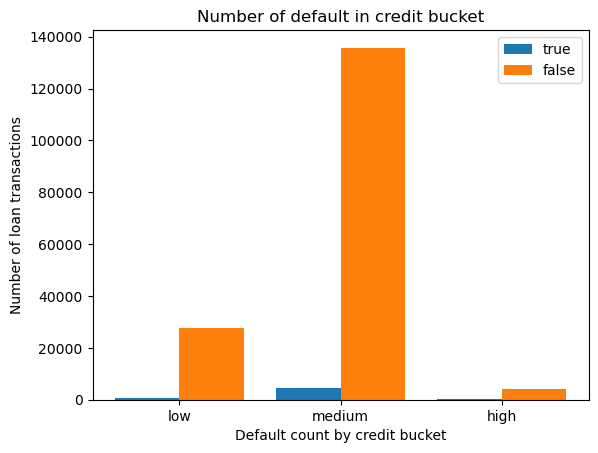

In [ ]:
## Default by credit bucket

# Prepare data for plotting
dataframe_credit = df_default_by_credit.select("credit_bucket", "is_default", "count").collect()

# Define dataset
credit_bucket = ["low", "medium", "high"]
is_default = [row["is_default"] for row in dataframe_credit]

credit_bucket_count = {"true": [], "false": []}

for row in dataframe_credit:
    credit_bucket_count[row["is_default"]].append(row["count"])

x = credit_bucket
y_true = credit_bucket_count["true"]
y_false = credit_bucket_count["false"]


# Set position of bar
x_axis = np.arange(len(x))

# Make the plot
plt.bar(x_axis - 0.2, y_true, 0.4, label = 'true')
plt.bar(x_axis + 0.2, y_false, 0.4, label = 'false')

plt.xticks(x_axis, x)

# Add labels and title
plt.xlabel("Default count by credit bucket")
plt.ylabel("Number of loan transactions")
plt.title("Number of default in credit bucket")

# Create legend and show graph
plt.legend()
plt.show()

### Default related to credit and income: default by credit bucket

In the above histogram, I plotted the number of defaults in each credit bucket.

As we can see, the medium credit applicants have the highest number of defaults, which is reasonable given the medium bucket contains most of the applicants. However, the default in low and high buckets are not obvious. I have made the following table to increase the readability of this visualisation.

|credit bucket|percentage of default|
| --- | --- |
| low | 2.07% |
| medium | 3.16% |
| high | 3.65% |

Surprisingly, applicants in high credit buckets have the highest percentage of default rate. One of my guesses is that high credit applicants tend to get larger amounts of loan compared to their income, which gives them the ability to make high risk investments, thus increasing their default risks.

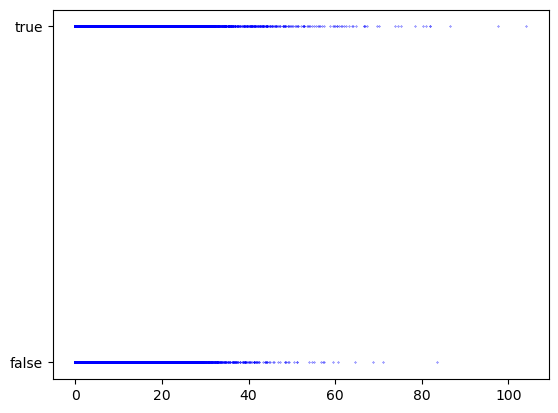

In [ ]:
## Default by total credit-to-income ratio

# Get the dataframe ready
df_default_by_ratio = (df_application
                       .select("total_credit_to_income_ratio", "is_default")
                      )

# Prepare data for plotting
dataframe_scatter = df_default_by_ratio.collect()

# Define dataset
total_credit_to_income_ratio = [row["total_credit_to_income_ratio"] for row in dataframe_scatter]
is_default = [row["is_default"] for row in dataframe_scatter]

x = total_credit_to_income_ratio
y = is_default

# Make the plot
plt.scatter(x, y, c = "blue", s = 0.08)

### Default related to credit and income: default by total credit-to-income ratio

Given the previous speculation that applicants with higher total credit-to-income ratio are more likely to default, I plotted this scatter plot to produce the visualisation about distribution of default based on total credit-to-income ratio.

For ratios under 35 to 40, the probability of default does not have a significant difference. From 40 to 85, there are more default situations than otherwise. From 85 above, according to this dataset, there have been no records showing non-default cases.

In [ ]:
## Default by gender
# Get the dataframe ready
# Adjust the dataframe for convience
df_default_by_gender = (df_application
                        .filter(col("gender") != "XNA")
                        .select("gender", "is_default")
                        .groupBy("gender", "is_default")
                        .count()
                        .sort("gender", "is_default")
                       )

df_default_by_gender.show()

+------+----------+------+
|gender|is_default| count|
+------+----------+------+
|     F|     false|109026|
|     F|      true|  4441|
|     M|     false| 58400|
|     M|      true|   721|
+------+----------+------+



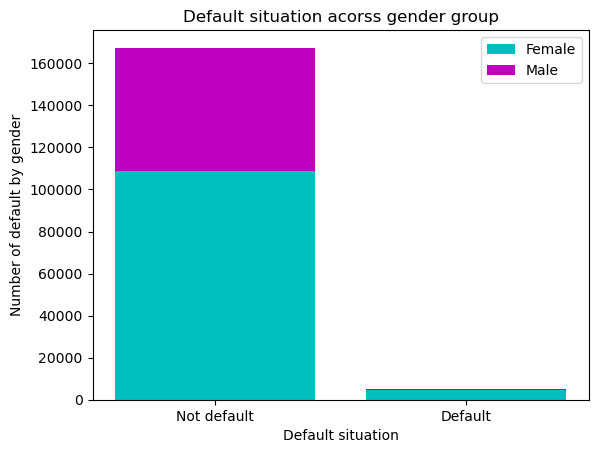

In [ ]:
## Default by gender

# Prepare data for plotting
dataframe_gender = df_default_by_gender.select("gender", "is_default", "count").collect()

# Define dataset
default_situation = ["Not default", "Default"]
gender = [row["gender"] for row in dataframe_gender]

gender_group_count = {"F": [], "M": []}

for row in dataframe_gender:
    gender_group_count[row["gender"]].append(row["count"])

x = default_situation
y_female = gender_group_count["F"]
y_male = gender_group_count["M"]

# Make the plot
plt.bar(x, y_female, color = "c", label = "Female")
plt.bar(x, y_male, bottom = y_female, color = "m", label = "Male")


# Add labels and title
plt.xlabel("Default situation")
plt.ylabel("Number of default by gender")
plt.title("Default situation acorss gender group")

# Create legend and show graph
plt.legend()
plt.show()

### Default by gender

This stacked bar chart visualise the distribution of default situations across gender.

To increase the readability of this graph, I made the following table:

|gender|percentage of default within gender group| gender percentage of all default|
| --- | --- | --- |
|Female| 3.91% | 86.03%|
|Male| 1.22% |13.97% |

The table shows majority cases of default are by female applicants. Within the same gender, the probability of female defaulting is around 4 in 100, while 3 in 200 for male. This does not necessarily mean that female applicants are more likely to default compared to males. In fact, based on the bank's decision, it seems that females are better loan candidates given the distribution of loan transactions. The reason behind these statistics could be social economic disadvantage against females, small sample size of loan application (especially for male), and other reasons we are not aware of.

## Part 2. Feature extraction and ML training <a class="anchor" name="part-2"></a>
In this section, you are only allowed to use PySpark DataFrame functions and ML packages for data preparation, model building, and evaluation. Other ML packages, such as scikit-learn, would receive zero marks. Excessive usage of Spark SQL is discouraged.
### 2.1 Discuss the feature selection and prepare the feature columns

2.1.1 Based on the data exploration from 1.2 and considering the use case, discuss the importance of those features. (For example, which features may be useless and should be removed, which feature has a great impact on the label column, which should be transformed) Which features you are planning to use? Discuss the reasons for selecting them and how you create/transform them
- 300 words max for the discussion
- Feel free to add/remove features based on your exploration

+------------+----------+-----+
|flag_contact|is_default|count|
+------------+----------+-----+
|           1|     false|19925|
|           1|      true| 1287|
|           2|     false|88291|
|           2|      true| 2335|
|           3|     false|38792|
|           3|      true|  971|
|           4|     false|19327|
|           4|      true|  535|
|           5|     false| 1094|
|           5|      true|   34|
+------------+----------+-----+



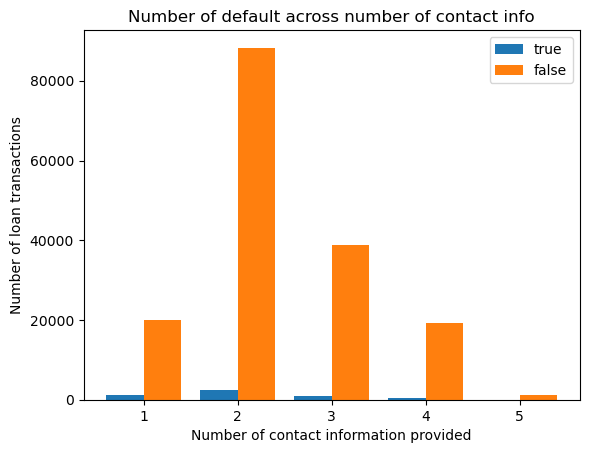

In [ ]:
## Explore "flag_contact"

# Create "flag_contact" by adding up flags of contact info provided
df_test = df_application.select("id_app", "flag_mobile", "flag_emp_phone", "flag_work_phone", "flag_phone", "flag_email", "is_default")

df_test = df_test.withColumn("flag_contact", col("flag_mobile") + col("flag_emp_phone") + col("flag_work_phone") + col("flag_phone") + col("flag_email"))

# Group number of default against number of contact provided
df_test = df_test.groupBy("flag_contact", "is_default").count().orderBy("flag_contact", "is_default").select("flag_contact", "is_default", "count")

df_test.show()

# Prepare data for plotting
dataframe_test = df_test.collect()

# Define dataset
flag_bucket = ["1", "2", "3", "4", "5"]
is_default = [row["is_default"] for row in dataframe_test]

flag_bucket_count = {"true": [], "false": []}

for row in dataframe_test:
    flag_bucket_count[row["is_default"]].append(row["count"])

x = flag_bucket
y_true_test = flag_bucket_count["true"]
y_false_test = flag_bucket_count["false"]


# Set position of bar
x_axis = np.arange(len(x))

# Make the plot
plt.bar(x_axis - 0.2, y_true_test, 0.4, label = 'true')
plt.bar(x_axis + 0.2, y_false_test, 0.4, label = 'false')

plt.xticks(x_axis, x)

# Add labels and title
plt.xlabel("Number of contact information provided")
plt.ylabel("Number of loan transactions")
plt.title("Number of default across number of contact info")

# Create legend and show graph
plt.legend()
plt.show()

### Discussion of features

1. Features to remove

- "id_app": only used for identifying applicants, does not provide useful information
- "target": not in use according to metadata file
- "age", "birthday": created for visulisation, repeated information
- "days_birth", "average_credit_score", "credit_score_1", "credit_score_2", "credit_score_3": the calculated field "age_bucket" and "credit_bucket" contains the simialr information respectively and are more useful
- "amt_credit_req_last_hour", "amt_credit_req_last_day", "amt_credit_req_last_week", "amt_credit_req_last_month", "amt_credit_req_last_quarter": only keeping "amt_credit_req_last_year", as the rest are repeated information
- "weekday_app_process_start", "hour_app_process_start": not useful information
- "region_population": not useful information
- "total_credit": repeated information with "total_credit_to_income_ratio"
- "own_car": repeated information given "own_car_age"

2. Features to transform

- Create "income_bucket" based on tax threshold, remove "income_total" as repeated information
- Create "flag_contact" as numerical value to the willingness of the applicant been contacted, remove "flag_mobile", "flag_emp_phone", "flag_work_phone", "flag_phone", "flag_email" as repeated information, but we leave out "flag_cont_mobile" as it measure whether the contact info provided are reachable

    As we can see from the exploration, there is most defualt case for those who provided no contact info. I calculated the table below to increase the readability of the visulisation, and noticed those who provide four contact have the second highest default rate, while those who provided two contact info have the lowest.

 |number of contact info | percentage of default within the group |
 | --- | --- |
 | 1 | 6.07% |
 | 2 | 2.58% |
 | 3 | 2.44% |
 | 4 | 2.69% |
 | 5 | 3.01% |    

3. Features to watch

- According to data exploration from 1.2, credit bucket, total credit-to-income ratio, and demographic information on applicants (such as gender, potentially marital status, ownership of car and property) may have a great impact on the label column.

- According to data exploration above, the willingness of applicants for providing contact info may associate with their probability to default.

2.1.2 Write code to create/transform the columns based on your discussion above.


In [ ]:
## Create income bucket

# This function takes income and produce income bucket value
def income_bucket(income):
    if income is None:
        income_bucket = 0
    else:
        income = int(income)
        if income <= 18200:
            income_bucket = 1
        elif income <= 45000:
            income_bucket = 2
        elif income <= 120000:
            income_bucket = 3
        elif income <= 180000:
            income_bucket = 4
        else:
            income_bucket = 5
    return income_bucket


# Register income_bucket as udf
income_bucket_udf = udf(income_bucket, IntegerType())

# Generate income bucket
df_application = df_application.withColumn("income_bucket", income_bucket_udf(col("income_total")))

df_application.select("income_total", "income_bucket").show()

+------------+-------------+
|income_total|income_bucket|
+------------+-------------+
|     90000.0|            3|
|    630000.0|            5|
|    112500.0|            3|
|    135000.0|            4|
|    135000.0|            4|
|     81000.0|            3|
|    135000.0|            4|
|    180000.0|            4|
|    180000.0|            4|
|     58500.0|            3|
|     90000.0|            3|
|     90000.0|            3|
|     67500.0|            3|
|    144000.0|            4|
|     67500.0|            3|
|    157500.0|            4|
|    225000.0|            5|
|     90000.0|            3|
|    135000.0|            4|
|     45000.0|            2|
+------------+-------------+
only showing top 20 rows



In [ ]:
## Creat flag_contact

df_application = df_application.withColumn("flag_contact", col("flag_mobile") + col("flag_emp_phone") + col("flag_work_phone") + col("flag_phone") + col("flag_email"))

df_application.select("flag_mobile", "flag_emp_phone", "flag_work_phone", "flag_phone", "flag_email", "flag_contact").show()

+-----------+--------------+---------------+----------+----------+------------+
|flag_mobile|flag_emp_phone|flag_work_phone|flag_phone|flag_email|flag_contact|
+-----------+--------------+---------------+----------+----------+------------+
|          1|             0|              0|         0|         0|           1|
|          1|             0|              0|         0|         0|           1|
|          1|             1|              0|         0|         0|           2|
|          1|             1|              0|         1|         0|           3|
|          1|             1|              0|         0|         0|           2|
|          1|             1|              1|         0|         0|           3|
|          1|             1|              0|         0|         0|           2|
|          1|             0|              0|         0|         0|           1|
|          1|             1|              0|         1|         0|           3|
|          1|             0|            

In [ ]:
## Drop columns

df_application = df_application.drop("id_app", "target", "age", "birthday", "days_birth", "average_credit_score", "credit_score_1", "credit_score_2", "credit_score_3", "income_total", "flag_mobile", "flag_emp_phone", "flag_work_phone", "flag_phone", "flag_email", "amt_credit_req_last_hour", "amt_credit_req_last_day", "amt_credit_req_last_week", "amt_credit_req_last_month", "amt_credit_req_last_quarter", "weekday_app_process_start", "hour_app_process_start", "region_population", "total_credit", "own_car")

df_application.printSchema()

root
 |-- contract_type: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- own_property: string (nullable = true)
 |-- num_of_children: integer (nullable = true)
 |-- amt_credit: float (nullable = true)
 |-- amt_annuity: float (nullable = true)
 |-- amt_goods_price: float (nullable = true)
 |-- income_type: string (nullable = true)
 |-- education_type: string (nullable = true)
 |-- family_status: string (nullable = true)
 |-- housing_type: integer (nullable = true)
 |-- days_employed: integer (nullable = true)
 |-- own_car_age: float (nullable = true)
 |-- flag_cont_mobile: integer (nullable = true)
 |-- occupation_type: string (nullable = true)
 |-- cnt_fam_members: float (nullable = true)
 |-- organization_type: integer (nullable = true)
 |-- days_last_phone_change: integer (nullable = true)
 |-- amt_credit_req_last_year: float (nullable = true)
 |-- loan_to_income_ratio: double (nullable = true)
 |-- age_bucket: string (nullable = true)
 |-- credit_bucket: string 

### 2.2 Preparing Spark ML Transformers/Estimators for features, labels, and models  <a class="anchor" name="2.2"></a>

2.2.1 Write code to create Transformers/Estimators for transforming/assembling the columns you selected above in 2.1, and create ML model Estimators for Random Forest (RF) and Gradient-boosted tree (GBT) model.  
**Please DO NOT fit/transform the data yet**

In [ ]:
numerical_cols = ['num_of_children', 'amt_credit', 'amt_annuity', 'amt_goods_price', 'days_employed', 'own_car_age', 'cnt_fam_members', 'days_last_phone_change', 'amt_credit_req_last_year', 'loan_to_income_ratio', 'num_of_prev_app', 'num_of_approved_app', 'total_credit_to_income_ratio', "income_bucket", "flag_contact"]

# "income_bucket", "flag_contact" are ordinal value and dont need string indexing or one hot encoding, therefore included in numerical_cols

string_cols = ['gender', 'education_type', 'income_type', 'family_status', 'occupation_type', 'own_property']

label_cols = ["is_default"]

ordinal_cols = ["credit_bucket", "age_bucket"]

nominal_cols = ['contract_type', 'housing_type', 'organization_type', 'flag_cont_mobile']

In [ ]:
# Define StringIndexer stages
indexers = [StringIndexer(inputCol = col, outputCol = col + "_index") for col in string_cols + ordinal_cols + label_cols]

# Define OneHotEncoder stages
encoders = [OneHotEncoder(inputCols=[col + "_index" if col in string_cols else col], outputCols=[col + "_vec"]) for col in nominal_cols + string_cols]

# Define VectorAssembler stage
assembler_cols = [col + "_vec" for col in nominal_cols + string_cols] + [col + "_index" for col in ordinal_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembler_cols, outputCol="features", handleInvalid="skip")



2.2.2 Write code to include the above Transformers/Estimators into two pipelines(RF and GBT).
**Please DO NOT fit/transform the data yet**

In [ ]:
# Create a Pipeline for RF and GBT
pipeline = Pipeline(stages=indexers + encoders + [assembler])

### 2.3 Prepare, Train and Evaluate models  
2.3.1 Write code to split the data for training and testing purposes. (Note: if the dataset is too large for your machine to train, sampling/sub-sampling is allowed.)

In [ ]:
# Fit and Transform the DataFrame for random forest model
pipelineModel = pipeline.fit(df_application)
df_transformed = pipelineModel.transform(df_application)

df_transformed.select("features").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(121,[63,68,72,73,81,86,107,108,109,110,111,112,113,114,115,116,117,118,119,120],[1.0,1.0,1.0,1.0,1.0,1.0,308133.0,16713.0,234000.0,-659.0,6.0,1.0,-638.0,1.0,3.2607,2.0,2.0,1.04,3.0,2.0])                              |
|(121,[44,67,69,73,80,86,103,104,105,107,108,109,110,111,112,114,115,116,117,118,119,120],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,2

In [ ]:
# Separate label from feature
df_transformed = df_transformed.withColumnRenamed('is_default_index', 'label')

In [ ]:
# Sample the dataset due to limited computation resources
percentage = 0.005
seed = 2024
df_sampled = df_transformed.sample(False, percentage, seed)

In [ ]:
## For RF model
# Splitting the data into testing and training set 80% into training and 20% for testing
train_rf, test_rf = df_sampled.randomSplit([0.8, 0.2], seed = 2024)

# Oversample label = 1 due to imbalanced data
train_1 = train_rf.where(col('label')==1).sample(True, 100.0, seed = 2024)
train_0 = train_rf.where(col('label')==0)
train_rf_oversampled = train_0.union(train_1)

### Reference [4]

In [ ]:
## For GBT model
#Splitting the data into testing and training set 80% into training and 20% for testing
train_gbt, test_gbt = df_sampled.randomSplit([0.8, 0.2], seed = 2024)

2.3.2 Write code to use the corresponding ML Pipelines to train the models on the training data. And then use the trained models to predict the testing data from 2.3.

In [ ]:
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

Model_rf = rf.fit(train_rf_oversampled)

Predictions_rf = Model_rf.transform(test_rf)
Predictions_rf.select("features", "label", "prediction").show()

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(121,[1,9,67,69,7...|  0.0|       0.0|
|(121,[1,44,68,70,...|  0.0|       0.0|
|(121,[17,67,69,73...|  0.0|       0.0|
|(121,[44,67,70,73...|  0.0|       0.0|
|(121,[23,67,69,74...|  0.0|       0.0|
|(121,[29,67,69,74...|  0.0|       0.0|
|(121,[39,67,69,75...|  0.0|       0.0|
|(121,[6,30,67,70,...|  0.0|       0.0|
|(121,[58,67,69,73...|  0.0|       0.0|
|(121,[10,67,70,74...|  0.0|       0.0|
|(121,[50,67,70,73...|  0.0|       0.0|
|(121,[36,67,69,74...|  0.0|       0.0|
|(121,[44,68,69,73...|  0.0|       0.0|
|(121,[58,68,69,73...|  0.0|       0.0|
|(121,[17,68,69,73...|  0.0|       0.0|
|(121,[17,68,71,73...|  0.0|       0.0|
|(121,[17,68,69,76...|  1.0|       0.0|
|(121,[1,39,68,69,...|  0.0|       0.0|
|(121,[13,67,69,73...|  0.0|       0.0|
|(121,[13,67,70,73...|  0.0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows



In [ ]:
gbt = GBTClassifier(featuresCol='features', labelCol='label')

Model_gbt = gbt.fit(train_gbt)

Predictions_gbt = Model_gbt.transform(test_gbt)
Predictions_gbt.select("features", "label", "prediction").show()

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(121,[1,9,67,69,7...|  0.0|       0.0|
|(121,[1,44,68,70,...|  0.0|       0.0|
|(121,[17,67,69,73...|  0.0|       0.0|
|(121,[44,67,70,73...|  0.0|       0.0|
|(121,[23,67,69,74...|  0.0|       0.0|
|(121,[29,67,69,74...|  0.0|       0.0|
|(121,[39,67,69,75...|  0.0|       0.0|
|(121,[6,30,67,70,...|  0.0|       0.0|
|(121,[58,67,69,73...|  0.0|       0.0|
|(121,[10,67,70,74...|  0.0|       0.0|
|(121,[50,67,70,73...|  0.0|       0.0|
|(121,[36,67,69,74...|  0.0|       0.0|
|(121,[44,68,69,73...|  0.0|       0.0|
|(121,[58,68,69,73...|  0.0|       0.0|
|(121,[17,68,69,73...|  0.0|       0.0|
|(121,[17,68,71,73...|  0.0|       0.0|
|(121,[17,68,69,76...|  1.0|       1.0|
|(121,[1,39,68,69,...|  0.0|       0.0|
|(121,[13,67,69,73...|  0.0|       0.0|
|(121,[13,67,70,73...|  0.0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows



2.4.2 For both models(RF and GBT) and testing data, write code to display the count of TP/TN/FP/FN. Compute the AUC, accuracy, recall, and precision for the above-threshold/below-threshold label from each model testing result using pyspark MLlib/ML APIs.
1. Draw an ROC plot.
2. Discuss which one is the better model and use metrics to support your claim (no word limit, please keep it concise)

In [ ]:
## Random Forest

# Calculate the elements of the confusion matrix
TN = Predictions_rf.filter('prediction = 0 AND label = 0').count()
TP = Predictions_rf.filter('prediction = 1 AND label = 1').count()
FN = Predictions_rf.filter('prediction = 0 AND label = 1').count()
FP = Predictions_rf.filter('prediction = 1 AND label = 0').count()
print(TP,TN,FP,FN)

0 53 0 2


In [ ]:
# ## Random Forest
#
# # Calculate metrics by the confusion matrix
# accuracy = (TP + TN)/(TP + TN + FP + FN)
# precision = TP/(TP + FP)
# recall = TP/(TP + FN)
#
#
# # Display the various metrics calculated above
# print(f'''
#     Accuracy: {accuracy}
#     Precision: {precision}
#     Recall: {recall}
#     ''')

# Due to the imbalanced data, in many cases, the calculation of confusion matrix would result in ZeroDivisionError
# I have attempted oversample the records where label = 1, but the result is not ideal

In [ ]:
## Random Forest

# Evaluate model by calculating AUC
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
auc_rf = evaluator.evaluate(Predictions_rf)

print(auc_rf)
print(evaluator.getMetricName())

0.7547169811320755
areaUnderROC


In [ ]:
## Gradient Boosting Tree

# Calculate the elements of the confusion matrix
TN = Predictions_gbt.filter('prediction = 0 AND label = 0').count()
TP = Predictions_gbt.filter('prediction = 1 AND label = 1').count()
FN = Predictions_gbt.filter('prediction = 0 AND label = 1').count()
FP = Predictions_gbt.filter('prediction = 1 AND label = 0').count()
print(TP,TN,FP,FN)

1 52 1 1


In [ ]:
## Gradient Boosting Tree

# Calculate metrics by the confusion matrix
accuracy = (TP + TN)/(TP + TN + FP + FN)
precision = TP/(TP + FP)
recall = TP/(TP + FN)


# Display the various metrics calculated above
print(f'''
    Accuracy: {accuracy}
    Precision: {precision}
    Recall: {recall}
    ''')


    Accuracy: 0.9636363636363636
    Precision: 0.5
    Recall: 0.5
    


In [ ]:
## Gradient Boosting Tree

# Evaluate model by calculating AUC
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
auc_gbt = evaluator.evaluate(Predictions_gbt)

print(auc_gbt)
print(evaluator.getMetricName())

0.9669811320754718
areaUnderROC


### Discussion

Due to limited computational resources, I am unable to perform hyper parameter tuning. Due to time constraints, I couldn't plot the ROC curves only using PySpark ML packages, therefore I would proceed with the model evaluation with available metrics.

The areaUnderROC for random forest model and gradient boosting model are 0.7547 and 0.9670 respectively. In addition, during the training and evaluation process, I noticed the random forest model is heavily impacted by the imbalance label in the dataset, resulting in poor performance.

Given the available information, the gradient boosting tree model is the better choice.

2.4.3 Save the better model, we will need this for Part B of assignment 2.
(note: You may need to go through a few training loops, adjust features, use more data and other techniques to create a better-performing model.)

In [ ]:
Model_gbt.save("loan_default_prediction_model")

### Part 3. Applicant Segmentation and Knowledge sharing with K-Mean <a class="anchor" name="part-3"></a>  
Please see the specification for this task and add code/markdown cells.
1. Utilize K-Mean clustering/hyperparameter tuning you have learned in this unit and try to find the optimal K value and train the model.
2. Based on your trained model parameters, make recommendations on how to segment the applicants. Write a paragraph with 300 words maximum.

In [ ]:
# Handle missing values due to the characteristic of k means clustering
df_application_cleaned = df_application.na.drop()

In [ ]:
numerical_cols = ['num_of_children', 'amt_credit', 'amt_annuity', 'amt_goods_price', 'days_employed', 'own_car_age', 'cnt_fam_members', 'days_last_phone_change', 'amt_credit_req_last_year', 'loan_to_income_ratio', 'num_of_prev_app', 'num_of_approved_app', 'total_credit_to_income_ratio', "income_bucket", "flag_contact"]

# "income_bucket", "flag_contact" are ordinal value and dont need string indexing or one hot encoding, therefore included in numerical_cols

string_cols = ['gender', 'education_type', 'income_type', 'family_status', 'occupation_type', 'own_property']

# remove label

ordinal_cols = ["credit_bucket", "age_bucket"]

nominal_cols = ['contract_type', 'housing_type', 'organization_type', 'flag_cont_mobile']

In [ ]:
# Define StringIndexer stages
indexers = [StringIndexer(inputCol = col, outputCol = col + "_index") for col in string_cols + ordinal_cols]

# Define OneHotEncoder stages
encoders = [OneHotEncoder(inputCols=[col + "_index" if col in string_cols else col], outputCols=[col + "_vec"]) for col in nominal_cols + string_cols]

# Define VectorAssembler stage
assembler_cols = [col + "_vec" for col in nominal_cols + string_cols] + [col + "_index" for col in ordinal_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembler_cols, outputCol="features", handleInvalid="skip")

In [ ]:
# Create a Pipeline k means clustering
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Fit and Transform the DataFrame for k means clustering model
pipelineModel = pipeline.fit(df_application_cleaned)
df_transformed = pipelineModel.transform(df_application_cleaned)

df_transformed.select("features").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(119,[63,67,72,73,80,84,105,106,107,108,109,110,111,112,113,114,115,116,117,118],[1.0,1.0,1.0,1.0,1.0,1.0,308133.0,16713.0,234000.0,-659.0,6.0,1.0,-638.0,1.0,3.2607,2.0,2.0,1.04,3.0,2.0])                              |
|(119,[44,68,69,73,79,84,101,102,103,105,106,107,108,109,110,112,113,114,115,116,117,118],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,2

In [ ]:
scaler = StandardScaler(inputCol="features",
                        outputCol="scaledFeatures",
                        withStd=True,
                        withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(df_transformed)

# Normalise each feature
df_scaled = scalerModel.transform(df_transformed)

df_scaled.select('scaledFeatures').show(5)

+--------------------+
|      scaledFeatures|
+--------------------+
|(119,[63,67,72,73...|
|(119,[44,68,69,73...|
|(119,[44,67,69,73...|
|(119,[39,68,70,75...|
|(119,[17,67,69,73...|
+--------------------+
only showing top 5 rows



Given k-means clustering is very sensitive to null values, I was unable to clean my dataset as required. Therefore, I cannot make recommendations on how to segment the applicants based on my own observation.

However, I have summarised a few guidelines on choosing the optimal number of clustering:
- When selecting the number of k, it is important to look at silhouette score, and a high silhouette score would indicate appropriate segmentation
- It's also helpful to plot sum of squared errors against k values, and find the point after which the SSE starts to decrease linearly

By following the above guidelines, we will be able to find the optimal k value.

### Part 4: Data Ethics, Privacy, and Security <a class="anchor" name="part-4"></a>  
Please see the specification for this task and add markdown cells(word limit: 500).

1. Defining concepts
- Data ethics: the process of how we handle data can have a positive or negative impact on our society, especially in the current data driven world. Data ethics requires us to provide sufficient consideration to the social impact when practising data processing.
    
- Data privacy: when collecting data, it is important to get consent from the owner of the data, and prevent unauthorised parties from accessing personal information.
    
- Data security: data security is about protecting data from leaking, theft and corruption during the process of data collection and analysing.

2. Topic: Examine real-world examples of how data ethics has been handled, positively and negatively.

    This topic is inspired by Invisible Women: Data Bias in a World Designed for Men. At the beginning of this book, Caroline Criado Perez introduced the snow cleaning schedule in Sweden as a data bias example. When setting up the schedule, men in the meeting room could not see that by cleaning pedestrian and cyclist paths first, it would reduce snow injuries in winter and save money for local governments. People who make this decision are not trying to be sexist, they are just primarily commuting using vehicles on the main road.
    
    It is difficult for people in an advantageous position to see the problems faced by those who aren't. This issue becomes more important in today's data driven world. For example, Google's image classification algorithm mistakenly labels the photo of an African couple as gorillas [1]. In the LLM training for generative AI, there are also concerns about reinforcing gender stereotypes when generating marketing content [2].
    
    However, there are positive scenarios where data ethics is addressed and awareness has been raised, one example is the non-binary option for gender in data collection [3]. By collecting data in a way that reflects real world situations, the data would be able to provide more insights in our analysis.
    
    By addressing data ethics in data collection and analysing processes, data science can make positive changes in today's data driven world.


## References:
Please add your references below:

[1] Grant, N., & Hill, K. (2023, May 22). Google’s Photo App Still Can’t Find Gorillas. And Neither Can Apple’s. The New York Times.

[2] Moni, S. (2023, July 25). Overcoming Algorithmic Gender Bias In AI-Generated Marketing Content. Forbes.

[3] Australian Bureau of Statistics. (2022, September 27). Analysis of non-binary sex responses. ABS. https://www.abs.gov.au/articles/analysis-non-binary-sex-responses.

[4] (n.d.). How to perform up-sampling using sample() function(py-spark). Stackoverflow. Retrieved February 2, 2024, from https://stackoverflow.com/questions/53273133/how-to-perform-up-sampling-using-sample-functionpy-spark